# Housing Price Prediction

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

In [2]:
data = pd.read_csv("Data/bengaluru_house_prices.csv")

In [3]:
data.shape

(13320, 9)

In [4]:
data = data.drop(["area_type", "society", "balcony", "availability"], axis="columns")
data

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00
...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453,4.0,231.00
13316,Richards Town,4 BHK,3600,5.0,400.00
13317,Raja Rajeshwari Nagar,2 BHK,1141,2.0,60.00
13318,Padmanabhanagar,4 BHK,4689,4.0,488.00


### Data Cleaning

In [5]:
data.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [6]:
data = data.dropna()
data.isna().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [7]:
data['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [8]:
data = data.copy()
data.loc[:, "BHK"] = data['size'].apply(lambda x: int(x.split(' ')[0]))

In [9]:
data["BHK"].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [10]:
data.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [11]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [12]:
data[~data["total_sqft"].apply(is_float)]

,location,size,total_sqft,bath,price,BHK
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
...,...,...,...,...,...,...
12975,Whitefield,2 BHK,850 - 1060,2.0,38.190,2
12990,Talaghattapura,3 BHK,1804 - 2273,3.0,122.000,3
13059,Harlur,2 BHK,1200 - 1470,2.0,72.760,2
13265,Hoodi,2 BHK,1133 - 1384,2.0,59.135,2


In [13]:
def convert_sqft_to_num(x):
    ranges = x.split('-')
    if len(ranges) == 2:
        return (float(ranges[0]) + float(ranges[1]))/2
    try:
        return float(x)
    except:
        return None

In [14]:
data = data.copy()
data['total_sqft'] = data['total_sqft'].apply(convert_sqft_to_num)

In [15]:
data

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2
...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5
13316,Richards Town,4 BHK,3600.0,5.0,400.00,4
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4


### Feature Engineering

In [16]:
data = data.copy()

In [17]:
data['price_per_sqft'] = (data['price'] * 100000) / data['total_sqft']
data

,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
...,...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5,6689.834926
13316,Richards Town,4 BHK,3600.0,5.0,400.00,4,11111.111111
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2,5258.545136
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4,10407.336319


In [18]:
len(data['location'].unique())

1304

In [19]:
data.location = data.location.apply(lambda x: x.strip())
location_statistics = data.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_statistics

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

In [20]:
len(location_statistics[location_statistics <= 10])

1052

In [21]:
location_statistics_less_than_10 = location_statistics[location_statistics <= 10]

In [22]:
data.location = data.location.apply(lambda x: 'Other' if x in location_statistics_less_than_10 else x)

In [23]:
data

,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
...,...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5,6689.834926
13316,Other,4 BHK,3600.0,5.0,400.00,4,11111.111111
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2,5258.545136
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4,10407.336319


### Outlier Removal

In [24]:
data[data.total_sqft/data.BHK < 300]

,location,size,total_sqft,bath,price,BHK,price_per_sqft
9,Other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,Other,3 Bedroom,500.0,3.0,100.0,3,20000.000000
...,...,...,...,...,...,...,...
13277,Other,7 Bedroom,1400.0,7.0,218.0,7,15571.428571
13279,Other,6 Bedroom,1200.0,5.0,130.0,6,10833.333333
13281,Margondanahalli,5 Bedroom,1375.0,5.0,125.0,5,9090.909091
13303,Vidyaranyapura,5 Bedroom,774.0,5.0,70.0,5,9043.927649


In [25]:
data = data[~(data.total_sqft/data.BHK < 300)]

In [26]:
data

,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
...,...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5,6689.834926
13316,Other,4 BHK,3600.0,5.0,400.00,4,11111.111111
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2,5258.545136
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4,10407.336319


In [27]:
data.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [28]:
def remove_outliers(dataFrame):
    data_frame_out = pd.DataFrame()
    for key, sub_data_frame in dataFrame.groupby('location'):
        mean = np.mean(sub_data_frame.price_per_sqft)
        std = np.std(sub_data_frame.price_per_sqft)
        reduced_data_frame = sub_data_frame[(sub_data_frame.price_per_sqft > (mean - std)) & 
                                            (sub_data_frame.price_per_sqft <= (mean + std))]
        data_frame_out = pd.concat([data_frame_out, reduced_data_frame], ignore_index=True)
    return data_frame_out

In [29]:
data = remove_outliers(data)

In [30]:
data

,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.00,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.00,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.00,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.00,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.00,2,11983.805668
...,...,...,...,...,...,...,...
10236,Yeshwanthpur,3 BHK,1676.0,3.0,92.13,3,5497.016706
10237,Yeshwanthpur,3 BHK,2503.0,3.0,138.00,3,5513.383939
10238,Yeshwanthpur,3 BHK,1855.0,3.0,135.00,3,7277.628032
10239,Yeshwanthpur,3 BHK,1876.0,3.0,160.00,3,8528.784648


In [31]:
def plot_scatter_graph(data, location):
    bhk_2 = data[(data.location == location) & (data.BHK == 2)]
    bhk_3 = data[(data.location == location) & (data.BHK == 3)]
    plt.rcParams['figure.figsize'] = (10, 6)
    plt.scatter(bhk_2.total_sqft, bhk_2.price, color='blue', label='2 BHK', s=50)
    plt.scatter(bhk_3.total_sqft, bhk_3.price, marker='+', color='green', label='3 BHK', s=50)
    plt.xlabel("Total Sqaure Feet Area")
    plt.ylabel("Price")
    plt.title(location)
    plt.legend()

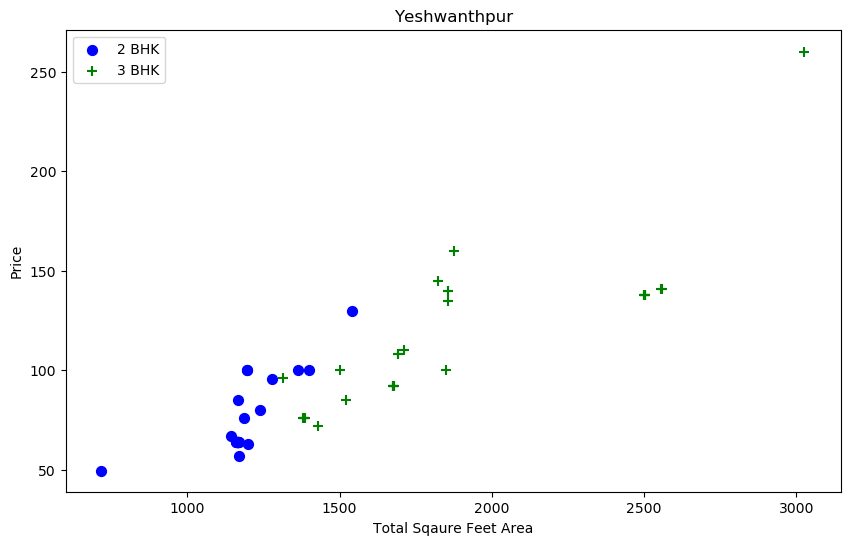

In [32]:
plot_scatter_graph(data, "Yeshwanthpur")

In [33]:
def remove_bhk_outliers(data):
    indices = np.array([])
    for location, location_data_frame in data.groupby('location'):
        bhk_statistics = {}
        for bhk, bhk_data_frame in location_data_frame.groupby('BHK'):
            bhk_statistics[bhk] = {
                'mean': np.mean(bhk_data_frame.price_per_sqft),
                'std': np.std(bhk_data_frame.price_per_sqft),
                'count':bhk_data_frame.shape[0]
            }
        for bhk, bhk_data_frame in location_data_frame.groupby('BHK'):
            statistics = bhk_statistics.get(bhk - 1)
            if statistics and statistics['count'] > 5:
                indices = np.append(indices, bhk_data_frame[bhk_data_frame.price_per_sqft < (statistics['mean'])].index.values)
    return data.drop(indices, axis='index')

In [34]:
data = remove_bhk_outliers(data)

In [35]:
data

,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668
...,...,...,...,...,...,...,...
10230,Yeshwanthpur,2 BHK,1195.0,2.0,100.0,2,8368.200837
10231,Yeshwanthpur,3 BHK,1692.0,3.0,108.0,3,6382.978723
10233,Yeshwanthpur,6 Bedroom,2500.0,5.0,185.0,6,7400.000000
10238,Yeshwanthpur,3 BHK,1855.0,3.0,135.0,3,7277.628032


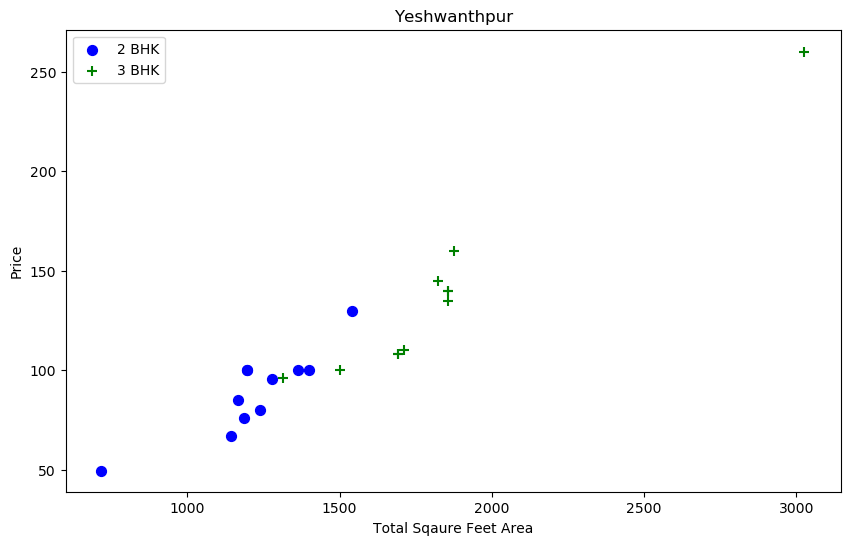

In [36]:
plot_scatter_graph(data, "Yeshwanthpur")

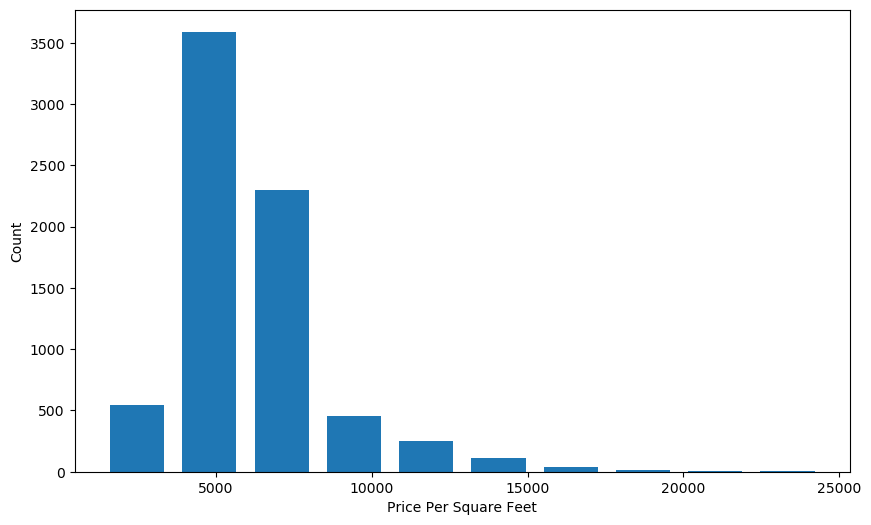

In [37]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.hist(data.price_per_sqft, rwidth=0.75)
plt.xlabel('Price Per Square Feet')
plt.ylabel('Count')
plt.show()

In [38]:
data.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

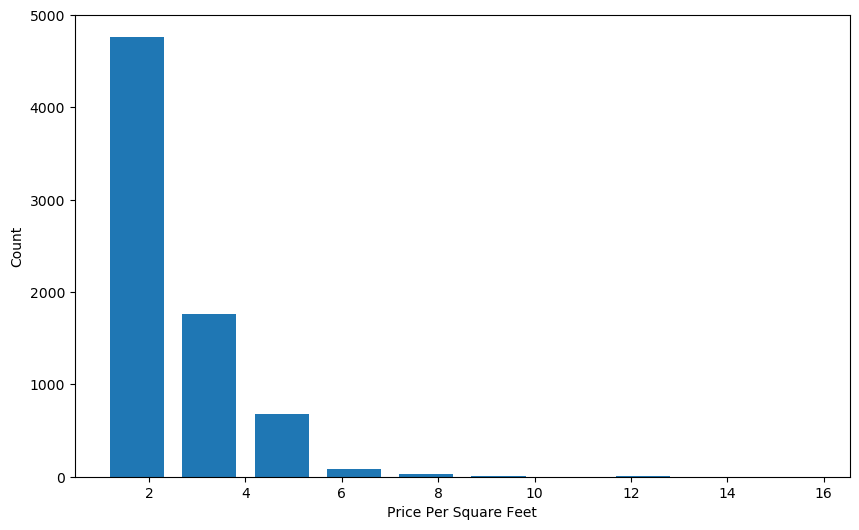

In [39]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.hist(data.bath, rwidth=0.75)
plt.xlabel('Price Per Square Feet')
plt.ylabel('Count')
plt.show()

In [40]:
data = data[data.bath < data.BHK + 2]
data

,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668
...,...,...,...,...,...,...,...
10230,Yeshwanthpur,2 BHK,1195.0,2.0,100.0,2,8368.200837
10231,Yeshwanthpur,3 BHK,1692.0,3.0,108.0,3,6382.978723
10233,Yeshwanthpur,6 Bedroom,2500.0,5.0,185.0,6,7400.000000
10238,Yeshwanthpur,3 BHK,1855.0,3.0,135.0,3,7277.628032


### Model Building

In [41]:
data = data.drop(['size', 'price_per_sqft'], axis='columns')

In [42]:
data

,location,total_sqft,bath,price,BHK
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2
...,...,...,...,...,...
10230,Yeshwanthpur,1195.0,2.0,100.0,2
10231,Yeshwanthpur,1692.0,3.0,108.0,3
10233,Yeshwanthpur,2500.0,5.0,185.0,6
10238,Yeshwanthpur,1855.0,3.0,135.0,3


In [43]:
dummies = pd.get_dummies(data.location)

In [44]:
data = pd.concat([data, dummies.drop('Other', axis='columns')], axis='columns')

In [45]:
data = data.drop('location', axis='columns')

In [46]:
data

,total_sqft,bath,price,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10230,1195.0,2.0,100.0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10231,1692.0,3.0,108.0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10233,2500.0,5.0,185.0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10238,1855.0,3.0,135.0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [47]:
X = data.drop('price', axis='columns')
y = data.price

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [49]:
model_linear_regression = LinearRegression()

In [50]:
model_linear_regression.fit(X_train, y_train)

LinearRegression()

In [51]:
model_linear_regression.score(X_test, y_test)

0.869191445217457

In [52]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

In [53]:
cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.85430675, 0.84187647, 0.84728412, 0.85171729, 0.87168018])

In [54]:
def find_best_model(X, y):
    algorithms = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params' : {}
        }, 
        'lasso':{
            'model':Lasso(),
            'params': {}
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {}
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algorithm_name, configuration in algorithms.items():
        grid_search = GridSearchCV(configuration['model'], configuration['params'], cv=cv, return_train_score=False)
        grid_search.fit(X, y)
        scores.append({
            'model': algorithm_name,
            'best_score': grid_search.best_score_,
            
        })
    return pd.DataFrame(scores, columns=['model', 'best_score'])

In [55]:
find_best_model(X, y)

,model,best_score
0,linear_regression,0.853373
1,lasso,0.727543
2,decision_tree,0.683784
